<a href="https://colab.research.google.com/github/zmarquis13/cortical_model_MNIST/blob/main/MNIST_cortical_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [13]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [14]:
lr = 0.1
batch_size = 64
epochs = 10

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


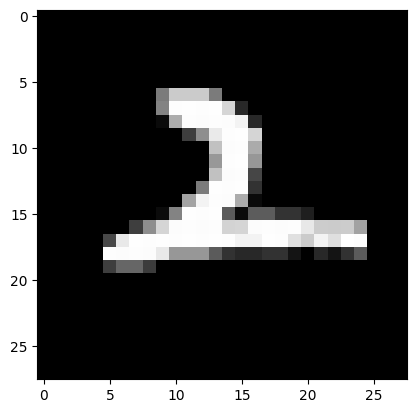

Label: 2


In [16]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [17]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [18]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        #input layer
        self.input = nn.Linear(28*28, 512)
        self.hidden = nn.Linear(512, 512)

        #cortex hidden layers
        self.cortex0 = nn.Linear(512, 10)
        self.cortex1 = nn.Linear(512, 10)
        self.cortex2 = nn.Linear(512, 10)
        self.cortex3 = nn.Linear(512, 10)
        self.cortex4 = nn.Linear(512, 10)



        #outputs for specific numbers
        self.output0 = nn.Linear(10, 1)
        self.output1 = nn.Linear(10, 1)
        self.output2 = nn.Linear(10, 1)
        self.output3 = nn.Linear(10, 1)
        self.output4 = nn.Linear(10, 1)

        #ouput for "I don't know"
        self.output5 = nn.Linear(10, 1)


    def forward(self, x):

        x = self.input(x)
        x = self.hidden(x)

        x0 = torch.relu(self.cortex0(x))
        x1 = torch.relu(self.cortex1(x))
        x2 = torch.relu(self.cortex2(x))
        x3 = torch.relu(self.cortex3(x))
        x4 = torch.relu(self.cortex4(x))

        x0 = self.output0(x0)
        x1 = self.output1(x1)
        x2 = self.output2(x2)
        x3 = self.output3(x3)
        x4 = self.output4(x4)


        x = torch.cat((x0, x1, x2, x3, x4), 1)

        #the value for the "unsure" output is 1 - sigmoid(sum(outputs 0-4))
        temp = torch.ones(x.size(0), 1)
        for i in range (x.size(0)):
          sum = 0
          for j in range(5):
            sum += x[1][j]
            temp[i] = 1 - torch.sigmoid(sum)

        zeros = torch.zeros(x.size(0), 4)
        intermediate = torch.cat((temp, zeros), 1)

        x = torch.cat((x, intermediate), 1)

        return x

model = NeuralNetwork()

In [19]:
# something to consider: data is 50% "null" and 10% of each of the classified numbers, may cause bias
# towards null but this is solvable by only including 1/6 of the null values

loss_fn = nn.CrossEntropyLoss()


In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # set model to train

    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X = X.view(X.shape[0],784)

        #generate prediction
        pred = model(X)

        # for all ground truths greater than 5, make them 5 (the "I don't know value")
        for i in range(y.size(0)):
              if y[i] > 5:
                y[i] = 5

        #calculate loss
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #print loss every 100 batches
        if batch % 100 == 99:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    # set model to eval
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    #disable gradient calculation
    with torch.no_grad():
        for X, y in dataloader:
            X = X.view(X.shape[0],784)

            pred = model(X)

            #for all ground truths greater than 5, make them 5 (the "I don't know value")
            for i in range(y.size(0)):
              if y[i] > 5:
                y[i] = 5

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Number Test Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
def test_static(mode, loss_fn):
  model.eval()

  with torch.no_grad():
    #size of about 10000 (10048)
    size = 157*64
    num_batches = 157
    test_loss, correct = 0, 0

    for i in range (num_batches):

      static = torch.rand(64, 784)
      pred = model(static)

      #set all labels to 5 (it's static so an "I don't know" is accurate)
      y = torch.ones(64, dtype=torch.long)
      y = y * 5

      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches

  correct /= 10048.0
  print(f"Static Test Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    test_static(model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.009162  [ 6400/60000]
loss: 1.033860  [12800/60000]
loss: 0.821061  [19200/60000]
loss: 0.604388  [25600/60000]
loss: 0.783856  [32000/60000]
loss: 0.935323  [38400/60000]
loss: 0.872530  [44800/60000]
loss: 0.709434  [51200/60000]
loss: 1.003004  [57600/60000]
Number Test Results: 
 Accuracy: 93.4%, Avg loss: 0.662800 

Static Test Results: 
 Accuracy: 100.0%, Avg loss: 0.917881 

Epoch 2
-------------------------------
loss: 0.587298  [ 6400/60000]
loss: 0.592821  [12800/60000]
loss: 0.757221  [19200/60000]
loss: 0.621650  [25600/60000]
loss: 0.762383  [32000/60000]
loss: 0.703448  [38400/60000]
loss: 0.855439  [44800/60000]
loss: 0.554001  [51200/60000]
loss: 0.718895  [57600/60000]
Number Test Results: 
 Accuracy: 91.7%, Avg loss: 0.722258 

Static Test Results: 
 Accuracy: 88.3%, Avg loss: 1.055454 

Epoch 3
-------------------------------
loss: 0.881703  [ 6400/60000]
loss: 0.587773  [12800/60000]
loss: 0.751596  [19200/60000]
loss: